In [1]:
import time
import os
import glob
import numpy as np
from PIL import Image
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Get each image filepath into a list
img_list = glob.glob("/home/srini/Downloads/DistractedDriver/train/**/*.jpg")
img_list[:5]

['/home/srini/Downloads/DistractedDriver/train/c7/img_70481.jpg',
 '/home/srini/Downloads/DistractedDriver/train/c7/img_71676.jpg',
 '/home/srini/Downloads/DistractedDriver/train/c7/img_94903.jpg',
 '/home/srini/Downloads/DistractedDriver/train/c7/img_72650.jpg',
 '/home/srini/Downloads/DistractedDriver/train/c7/img_73378.jpg']

In [2]:
# Load in ALL train images and label them
actual_images = []
X = []
y = []

start = time.time()

for j in range(10):
    print('Load folder c{}'.format(j))
    path = os.path.join('.', 'train', 'c' + str(j), '*.jpg')
    img_list = glob.glob(path)
    for file in img_list:
        # Open each image and convert to black and white
        img = Image.open(file).convert('L')
        # Get image height and width to divide each by 2 (save memory)
        height, width = img.size
        # thumbnail is an in-place operation
        img.thumbnail((height/4, width/4), Image.ANTIALIAS)
        # Make each image into a numpy array divided by the max to get 0 to 1 normalization
        img_data = np.array(img.getdata()) / 255
        # Grow lists of actual images, image data, and labels
        actual_images.append(img)
        X.append(img_data)
        y.append(j)
# Combine list of images into numpy array
X = np.array(X, dtype = 'float32')    

end = time.time()

print()
print("Loading and cleaning images took %s" % str(end - start), "seconds", '\n')
print("Number of train images: %s" % len(X))

Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9

Loading and cleaning images took 176.488431930542 seconds 

Number of train images: 22424


[0, 2, 4, 6]


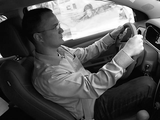

In [3]:
# Show an example of an image and some labels
print(y[0:20000:5000])
actual_images[0]

In [4]:
# Make sure to save both the cleaned inputs and the cleaned target
X_h5 = h5py.File('X.h5', 'w')
X_h5.create_dataset('X_h5', data=X)
X_h5.close()

y_h5 = h5py.File('y.h5', 'w')
y_h5.create_dataset('y_h5', data=y)
y_h5.close()

Now with our images preprocessed and put into numeric format, we can move forward with dividing up the samples into test and train data We then also need to make sure the data shape is prepared in Tensorflow format and that the labels are dummy coded so that Keras can interpret the labels correctly.

In [5]:
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, Callback
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten
from keras.utils import to_categorical
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

# This make sure the input shape is: (number of samples, width, height, channels)
# K.set_image_dim_ordering('tf')
K.tensorflow_backend.set_image_dim_ordering('tf')

# Load in preprocessed data
with h5py.File('X.h5', 'r') as hf:
    X = hf['X_h5'][:]
with h5py.File('y.h5', 'r') as hf:
    y = hf['y_h5'][:]

# Get train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, shuffle = True)

# Prepare images to correct shape for Keras model
X_train = X_train.reshape(X_train.shape[0], 160, 120, 1)
X_test= X_test.reshape(X_test.shape[0], 160, 120, 1)
y_train = to_categorical(y_train).astype('int32')
y_test = to_categorical(y_test).astype('int32')

# Check data to see if everything is ok
print(" 'X' matrix/input ")
print("Shape: ", str(X_train.shape))
print(X_train[0][0][:5], '\n')
print(" 'y' label/output ")
print("Shape: ", str(y_train.shape))
print(y_train)

Using TensorFlow backend.
/home/srini/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


 'X' matrix/input 
Shape:  (17939, 160, 120, 1)
[[0.12156863]
 [0.12156863]
 [0.12156863]
 [0.12156863]
 [0.13725491]] 

 'y' label/output 
Shape:  (17939, 10)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]]


In [6]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 14351 samples, validate on 3588 samples
Epoch 1/15
14351/14351 [==============================] - 1547s 108ms/step - loss: 1.2630 - acc: 0.5602 - val_loss: 0.6385 - val_acc: 0.8250
Epoch 2/15
14351/14351 [==============================] - 1534s 107ms/step - loss: 0.2913 - acc: 0.9068 - val_loss: 0.1507 - val_acc: 0.9551
Epoch 3/15
14351/14351 [==============================] - 1528s 106ms/step - loss: 0.1231 - acc: 0.9624 - val_loss: 0.0848 - val_acc: 0.9769
Epoch 4/15
14351/14351 [==============================] - 1515s 106ms/step - loss: 0.0552 - acc: 0.9825 - val_loss: 0.0489 - val_acc: 0.9877
Epoch 5/15
14351/14351 [==============================] - 1499s 104ms/step - loss: 0.0289 - acc: 0.9919 - val_loss: 0.0389 - val_acc: 0.9900
Epoch 6/15
14351/14351 [=====

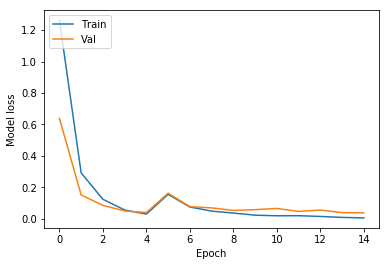

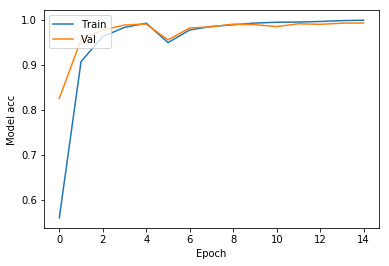

In [7]:
batch_size = 32

# Use next line if not doing cosine annealing
# early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

schedule = SGDRScheduler(min_lr=1e-4,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(X_train.shape[0]/batch_size),
                         lr_decay=0.8,
                         cycle_length=5,
                         mult_factor=2)

def DD_VGG():
    model = Sequential()
    # Use Batch Normalization for every conv and dense layers
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (160, 120, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.33))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation = 'softmax')) # Sigmoid for log loss?
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

driver_model = DD_VGG()
driver_hist = driver_model.fit(X_train, y_train, epochs=15, batch_size=batch_size, verbose=1,
                               validation_split=0.2, callbacks=[schedule])

def plot_model(model_hist, train_metric, val_metric):
    plt.plot(model_hist[train_metric])
    plt.plot(model_hist[val_metric])
    plt.ylabel('Model ' + str(train_metric))
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_model(driver_hist.history, 'loss', 'val_loss')
plot_model(driver_hist.history, 'acc', 'val_acc')

In [8]:
# Save model when retraining
driver_model.save('./driver_model.h5')
#driver_model = load_model('./driver_model.h5')

# Save model history
with open('./trainHistoryDict', 'wb') as history:
        pickle.dump(driver_hist.history, history)

In [9]:
# Get predictions and make them into vector of 0 to 9
test_pred = driver_model.predict(X_test)
test_pred2 = np.argmax(test_pred, axis = 1)

# Change dummy code matrix back to vector of 0 to 9
y_test2 = np.argmax(y_test, axis = 1)

# Get performance
print(confusion_matrix(y_test2, test_pred2))
print("Test set accuracy is: %s" % accuracy_score(y_test2, test_pred2))

[[497   0   0   0   0   0   0   0   0   0]
 [  0 439   0   0   0   0   0   0   0   0]
 [  1   0 463   1   0   0   1   0   0   0]
 [  0   0   1 442   1   0   0   0   0   0]
 [  1   0   0   2 497   0   2   0   1   0]
 [  1   0   0   0   0 483   0   0   0   0]
 [  0   0   0   0   0   0 464   0   0   0]
 [  0   1   0   1   0   0   0 393   1   1]
 [  3   0   0   0   0   0   0   1 379   1]
 [  0   0   0   0   0   1   0   0   2 404]]
Test set accuracy is: 0.9946488294314382
